### Import Block

In [1]:
import h5py
import pickle
import os
import gc

import numpy as np
import math
import torch 
import torch.nn as nn
from functools import partial

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import time
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns
import imageio
import pandas as pd
from statsmodels.tsa.stattools import adfuller

from dls_funcs import * # Imports gfem_2d, gfem_recon and related functions
from analysis_funcs import * # Imports analysis functions


### User-set Parameters

In [2]:
# Model Load
use_trained_model = False

# Latent parameters
patch_size  = 19
num_modes   = 5

# Model size parameters
time_lag    = 64
d_model     = 512
nhead       = 4
num_layers  = 4

# Training parameters
lr          = 0.001
num_epochs  = 1000
patience    = 25
train_ahead = 5
train_size  = 8334
test_split  = 0.1
val_split   = 0.2
batch_size  = 256

# Data name, assumed in data/ directory
data_name   = 'ldc_30k_60ksnaps'  
# data_name = 'ldc_15k'

# Overwrite flag, for if everything needs to be re-run
overwrite_latent        = False
overwrite_latent_eval   = False
overwrite_true_stats    = False
seed                    = 42

animate_flag            = False
visualize_flow_flag     = False

# ram_needed = ?
ram_available = 100 # GB


num_train   = int(train_size * (1 - val_split))
num_test, num_train = int(num_train * test_split), int(num_train * (1 - test_split))
num_val     = int(train_size * val_split)
print('num_train:', num_train)
print('num_test:', num_test)
print('num_val:', num_val)

num_train: 6000
num_test: 666
num_val: 1666


### Make Directories

In [3]:
fig_dir = 'figs/' + data_name + '/'
latent_id = 'm' + str(num_modes) + 'p' + str(patch_size) + '/'
anim_dir = 'anim/' + data_name + '/'

os.makedirs('figs', exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(fig_dir + latent_id, exist_ok=True)
os.makedirs('anim', exist_ok=True)
os.makedirs(anim_dir, exist_ok=True)
os.makedirs(anim_dir + latent_id, exist_ok=True)

### Check Data Sizes

In [4]:
# Check if data file exists, and print size
file = 'data/' + data_name + '.h5'
with h5py.File(file, 'r') as f:
    print('Data set shape:', f['UV'].shape)
    print('Data mean shape:', f['mean'].shape)
    if train_size > f['UV'].shape[0]:
        print('Warning: train_size is larger than data set size. Setting train_size to data set size.')
        train_size  = f['UV'].shape[0]
        num_train   = int(train_size * (1 - val_split))
        num_test    = int(train_size * test_split)
        num_val     = int(train_size * val_split)


latent_name = 'dls_' + data_name + '_m' + str(num_modes) + '_p' + str(patch_size)
latent_file = 'latent/' + latent_name + '.h5'
latent_config = 'latent/' + latent_name + '_config.pkl'
latent_metrics = 'latent/' + latent_name + '_metrics.txt'

with open(latent_config, 'rb') as f:
    config = pickle.load(f)

num_dofs = 2*config.num_gfem_nodes * config.dof_node
max_coeffs = (train_size - time_lag - train_ahead, time_lag + train_ahead, num_dofs)
print('Max coeffs:', math.prod(max_coeffs))
print('Bytes of Max coeffs:', math.prod(max_coeffs) *4)
print('GB of Max coeffs:', math.prod(max_coeffs) *4 / 1e9)

Data set shape: (60000, 512, 512, 2)
Data mean shape: (512, 512, 2)
Max coeffs: 22234271580
Bytes of Max coeffs: 88937086320
GB of Max coeffs: 88.93708632


### Compute TKE for Data

In [5]:
# save TKE to new field in data_path h5 if field doesn't exist
with h5py.File(file, 'r+') as f:
    if 'TKE' in f.keys():
        TKE = f['TKE'][:]
        print('TKE field already exists in file.')
    else:
        print('TKE field does not exist. Creating new field.')
        TKE = TKE_long(data_path = file, field_name = 'UV', axis_order = [3, 1, 2, 0])
        f.create_dataset('TKE', data=TKE)

TKE field already exists in file.


## Data and Latent Evaluation

### Latent Space Creation or Loading

In [6]:
latent_name = 'dls_' + data_name + '_m' + str(num_modes) + '_p' + str(patch_size)
latent_file = 'latent/' + latent_name + '.h5'
latent_config = 'latent/' + latent_name + '_config.pkl'
latent_metrics = 'latent/' + latent_name + '_metrics.txt'

if os.path.exists(latent_file) and not overwrite_latent:
    print('Loading latent space from file...')
    # with h5py.File(latent_file, 'r') as f:
    #     dof_u = f['dof_u'][:]
    #     dof_v = f['dof_v'][:]
    with open(latent_config, 'rb') as f:
        config = pickle.load(f)
    with open(latent_metrics, 'r') as f:
        metrics = f.readlines()
        print('Metrics:')
        for line in metrics:
            print(line.strip())
    print('Latent space exists in file')

    
else:
    # Compute the latent space using the DLS method
    print('Computing latent space...')
    start = time.time()
    config = gfem_2d_long(file, 'UV', latent_file, patch_size, num_modes, batch_size = 2499 )
    end = time.time()
    compress_time = end - start
    print('Time taken to compute latent space: ', end - start)

    # Save the config
    with open(latent_config, 'wb') as f:
        pickle.dump(config, f, pickle.HIGHEST_PROTOCOL)

    # write metrics to text file
    with open(latent_metrics, 'w') as f:
        f.write(f'Compression Time: {compress_time:.2f}s\n')
        f.write(f'Compression ratio: {config.compression_ratio:.2f}x\n')
        f.write(f'Number of Modes: {num_modes}\n')
        f.write(f'Patch Size: {patch_size}\n')

Loading latent space from file...
Metrics:
Compression Time: 5881.64s
Compression ratio: 43472.70x
Number of Modes: 5
Patch Size: 19
Latent space exists in file


### Compute Latent Statistics

In [7]:
with h5py.File(latent_file, 'r+') as f:
    if 'RMS' in f.keys() and not overwrite_latent_eval:
        print('Latent statistics already exist.')
        latent_RMS = f['RMS'][:]
        latent_TKE = f['TKE'][:]
        l2_err = f['L2_err'][:]
        true_TKE = f['true_TKE'][:]
    else:
        print('Latent statistics dont exist. Creating new field.')
        l2_err, latent_RMS, latent_TKE, true_TKE = latent_eval(data_path = file, latent_path = latent_file, field_name = 'UV', axis_order= [3, 1, 2, 0], config = config, snap_end=2499)
        
        if 'RMS' in f.keys():
            del f['RMS']
        f.create_dataset('RMS', data=latent_RMS)

        if 'TKE' in f.keys():
            del f['TKE']
        f.create_dataset('TKE', data=latent_TKE)

        if 'L2_err' in f.keys():
            del f['L2_err']
        f.create_dataset('L2_err', data=l2_err)

        if 'true_TKE' in f.keys():
            del f['true_TKE']
        f.create_dataset('true_TKE', data=true_TKE)

Latent statistics already exist.


In [8]:
# error in TKE
TKE_err = np.linalg.norm(true_TKE - latent_TKE) / np.linalg.norm(true_TKE)
print(f'L2 Error Norm of TKE: {TKE_err*100:.2f}%')
print('Average L2 error:', 100*np.mean(l2_err), '%')

L2 Error Norm of TKE: 0.00%
Average L2 error: 0.8666498750723282 %


### Check Original vs Compressed Data

#### Vorticity Function

In [9]:
def curl(x,y,u,v):
    dx = x[0, 1] - x[0, 0]  # Calculate scalar spacing in x-direction
    dy = y[1, 0] - y[0, 0]  # Calculate scalar spacing in y-direction
    # print(u.shape, v.shape)
    dummy, dFx_dy = np.gradient(u, dy, dx, axis=[0,1])  # Note the order of dy and dx
    dFy_dx, dummy = np.gradient(v, dy, dx, axis=[0,1])  # Note the order of dy and dx

    rot = dFy_dx - dFx_dy

    return rot

In [10]:
if visualize_flow_flag:
    grid_x = np.linspace(1, 512, 512)
    grid_y = np.linspace(1, 512, 512)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)

    N, M = 6, 5
    fig, axes = plt.subplots(N, M, sharey=True, sharex=True, figsize=(2*M, 2*N), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

    with h5py.File(file, 'r') as f:
        u_scaled = f['UV'][:500:100].transpose(3,1,2,0)
        u_mean = f['mean'][:].transpose(2,0,1)

    vort = curl(grid_x, grid_y, u_scaled[0], u_scaled[1])
    vort = vort[:config.nx_t,:config.ny_t,:]
    u_scaled = u_scaled[:,:config.nx_t,:config.ny_t,:]

    with h5py.File(latent_file, 'r') as f:
        dof_u = f['dof_u'][:500:100]
        dof_v = f['dof_v'][:500:100]

    u_rec = gfem_recon(dof_u.T, dof_v.T, config)
    u_rec = u_rec + u_mean[:,:config.nx_t,:config.ny_t, np.newaxis]

    vort_rec = curl(grid_x, grid_y, u_rec[0], u_rec[1])

    vmax = np.max(np.abs(vort))

    for j in range(M):
        ax = axes[0,j]
        ax.imshow(vort[...,j], origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
        ax.axis('off')

        ax = axes[1,j]
        ax.imshow(vort_rec[...,j], origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
        ax.axis('off')

    u_scaled = u_scaled - u_mean[:,:config.nx_t,:config.ny_t, np.newaxis]
    u_rec = u_rec - u_mean[:,:config.nx_t,:config.ny_t, np.newaxis]

    vmax = np.max(np.abs(u_rec[0]))

    for j in range(M):
        ax = axes[2,j]
        ax.imshow(u_scaled[0][...,j], origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
        ax.axis('off')

        ax = axes[3,j]
        ax.imshow(u_rec[0][...,j], origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
        ax.axis('off')

    vmax = np.max(np.abs(u_rec[1]))

    for j in range(M):
        ax = axes[4,j]
        ax.imshow(u_scaled[1][...,j], origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
        ax.axis('off')

        ax = axes[5,j]
        ax.imshow(u_rec[1][...,j], origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)


    for j in range(M):
        ax = axes[0,j]
        ax.set_title(f'Step {(j+1)*100}')

    plt.show()

In [11]:
if visualize_flow_flag:
    with h5py.File(file, 'r') as f:
        u_mean = f['mean'][:].transpose(2,0,1)
        vort_mean = curl(grid_x, grid_y, u_mean[0], u_mean[1])
        
        vmax = np.max(np.abs(vort_mean))
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(vort_mean[:,:], origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax)
        ax.set_title('Mean Flow Vorticity')
        ax.axis('off')
        # show colorbar
        cbar = plt.colorbar(ax.imshow(vort_mean, origin='lower', cmap='seismic', vmin=-vmax, vmax=vmax), ax=ax, pad=0.02,shrink=0.85)

In [12]:
if visualize_flow_flag:
    # Plot streamlines of the mean flow
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.streamplot(grid_x, grid_y, u_mean[0], u_mean[1], color='k', linewidth=0.5, broken_streamlines=False, density=1.5, minlength=0)
    ax.set_title('Mean Flow Streamlines')
    for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(fig_dir + 'mean_flow_streamlines.png', dpi=600)

## Data Handling

### Import and Modify Latent Data for Training

In [13]:
with h5py.File(latent_file, 'r') as f:
    print('Latent space shape:', f['dof_u'].shape)

    dof_u = f['dof_u'][:train_size]
    dof_v = f['dof_v'][:train_size]
    print('Train data shape:', dof_u.shape)

Latent space shape: (60000, 19494)


Train data shape: (8334, 19494)


In [14]:
reshaped_data = np.concatenate((dof_u , dof_v), axis=1)
print('New data shape:',reshaped_data.shape)
del dof_u, dof_v

New data shape: (8334, 38988)


#### Normalize data set with standard scaler

In [15]:
# normalization functions
def normalize_data(data, mean, std):
    return (data - mean) / std
def denormalize_data(data, mean, std):
    return (data * std) + mean

# data mean and std
std_data = np.std(reshaped_data, axis=(0))
mean_data = np.mean(reshaped_data, axis=(0))

normalized_data = normalize_data(reshaped_data, mean_data, std_data)

print('Normalized data max: ', np.max(normalized_data), ', min:', np.min(normalized_data))

del reshaped_data

Normalized data max:  14.803727 , min: -17.379093


In [16]:
# Split the data into training and validation sets
train_data = normalized_data[:num_train].astype(np.float32)
test_data = normalized_data[num_train:num_train + num_test].astype(np.float32)
val_data = normalized_data[num_train + num_test:num_train + num_test + num_val].astype(np.float32)

print('Training set is shape:', train_data.shape)
print('Testing set is shape:', test_data.shape)
print('Validation set is shape:', val_data.shape)

Training set is shape: (6000, 38988)
Testing set is shape: (666, 38988)
Validation set is shape: (1666, 38988)


In [17]:
def make_Sequence(time_lag,data,pred_length=5):
    """
    Generate time-delay sequence data 

    Args: 
        time_lag: Time lag for the sequence
        data: A numpy array follows [Ntime, Nmode] shape
        pred_length: Prediction length for the sequence

    Returns:
        X: Numpy array for Input 
        Y: Numpy array for Output
    """

    from tqdm import tqdm 
    import numpy as np 

    nSamples    = data.shape[0]-time_lag-pred_length
    X           = np.zeros([nSamples, time_lag,    data.shape[-1]]).astype(np.float32)
    Y           = np.zeros([nSamples, pred_length, data.shape[-1]]).astype(np.float32)
    # Fill the input and output arrays with data
    for j in tqdm(np.arange(data.shape[0]-time_lag-pred_length)):
        X[j,:,:] = data[j: j+time_lag,:]
        Y[j,:,:] = data[j+time_lag: j+time_lag+pred_length, :]

    return X, Y

X_test, Y_test   = make_Sequence(time_lag,test_data)
# X_val, Y_val     = make_Sequence(time_lag,val_data)

X_train, Y_train = make_Sequence(time_lag,train_data)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")
# print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

100%|██████████| 5931/5931 [00:12<00:00, 481.94it/s]

X_train shape: (5931, 64, 38988), Y_train shape: (5931, 5, 38988)
X_test shape: (597, 64, 38988), Y_test shape: (597, 5, 38988)


In [18]:
del train_data, test_data

In [19]:
gc.collect()

0

In [20]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# clear GPU memory
torch.cuda.empty_cache()

Using device: cuda


In [21]:
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
# X_val = torch.tensor(X_val, dtype=torch.float32)
# Y_val = torch.tensor(Y_val, dtype=torch.float32)

In [22]:
gc.collect()

0

In [23]:
X_train = torch.tensor(X_train, dtype=torch.float32)

## Create and Train Model
The architecture used is a Transformer Encoder trained in an autoregressive manner

**Architecture**

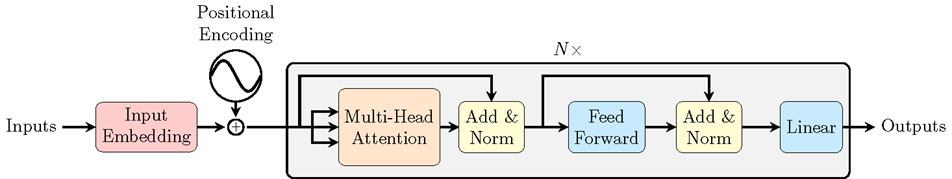

**Autoregression**

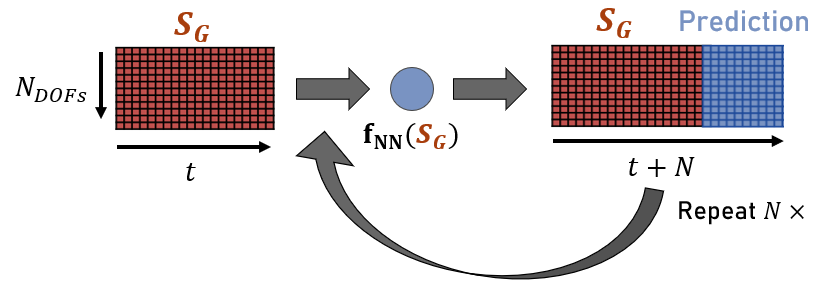

In [ ]:
# Positional encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=time_lag, dropout=0):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Define the Transformer Encoder model
class TransformerEncoderModel(nn.Module):
    def __init__(self, time_lag, input_dim, d_model=256, nhead=4, num_layers=4):
        super(TransformerEncoderModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=time_lag)
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, input_dim)

        # Attention outputs storage
        self.encoder_attn_outputs = {}
        self.patch_attention()

    def patch_attention_layer(self, m):
        """Monkey-patch the attention layer to save attention weights."""
        forward_orig = m.forward

        def wrap(*args, **kwargs):
            kwargs["need_weights"] = True
            kwargs["average_attn_weights"] = False
            return forward_orig(*args, **kwargs)

        m.forward = wrap

    def patch_attention(self):
        """Patch all attention layers in the encoder."""
        for i, layer in enumerate(self.encoder_layers):
            self.patch_attention_layer(layer.self_attn)
            layer.self_attn.register_forward_hook(partial(self.save_output_encoder, label=f's{i}'))

    def save_output_encoder(self, m, i, o, label='0'):
        """Save the attention weights from the encoder."""
        self.encoder_attn_outputs[label] = o[1].cpu().detach()

    def get_attn(self):
        """Retrieve the saved attention weights."""
        return self.encoder_attn_outputs.copy()

    def forward(self, x):
        x = self.input_projection(x)
        x = self.positional_encoding(x)

        for layer in self.encoder_layers:
            x = layer(x)
            
        x = self.fc(x[:, -1, :])
        return x

# Initialize the model and move it to the GPU
input_dim = X_train.shape[-1]
model = TransformerEncoderModel(time_lag, input_dim, d_model=d_model, nhead=nhead, num_layers=num_layers).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


### Train Loop

In [ ]:
# Data loaders
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

if not use_trained_model:
    # Train the model
    best_test_loss = float('inf')
    max_norm = 2.0
    losses = []
    test_losses = []

    # Training loop
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            total_loss = 0.0

            for n in range(targets.shape[1]):
                target = targets[:, n, :]  # shape: [B, 38988]

                # Forward pass
                outputs = model(inputs)  # shape: [B, 38988]
                loss = criterion(outputs, target)

                # Backward and optimization for current step only
                total_loss += loss
                loss.backward()

                # Prepare input for next step
                inputs = torch.cat((inputs[:, 1:, :], outputs.detach().unsqueeze(1)), dim=1)
                
            # total_loss.backward()
            epoch_loss += total_loss.item() / targets.shape[1]

            optimizer.step()

        losses.append(epoch_loss / len(train_loader))
        

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                # Move inputs and targets to the GPU
                inputs, targets = inputs.to(device), targets.to(device)
                for n in range(targets.shape[1]):
                    target = targets[:, n, :]  
                    outputs = model(inputs)
                    loss = criterion(outputs, target)
                    test_loss += loss.item() / targets.shape[1]
                    inputs = torch.cat((inputs[:, 1:, :], outputs.unsqueeze(1)), dim=1)
            
        test_losses.append(test_loss / len(test_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

        if epoch > 0:
            if np.isnan(test_losses[-1]) or np.isnan(losses[-1]):
                print(f'NaN loss at epoch {epoch+1}. Stopping training.')
                model.load_state_dict(best_model)
                break
            elif test_loss / len(test_loader) < best_test_loss:
                best_test_loss = min(test_losses)
                best_model = model.state_dict()
                early_stop_counter = 0
                
                # checkpoint model
                torch.save(model.state_dict(), 'checkpoints/' + data_name + '_best_model.pth')
                print(f'Best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}')
            
            elif test_loss / len(test_loader) >= best_test_loss:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    model.load_state_dict(best_model)
                    break

    end_time = time.time()
    print('Time taken for training: ', end_time - start_time)
    print('Time taken per epoch: ', (end_time - start_time)/num_epochs)

Epoch [1/1000], Train Loss: 0.8105, Test Loss: 0.7513
Epoch [2/1000], Train Loss: 0.5804, Test Loss: 0.6443
Epoch [3/1000], Train Loss: 0.4561, Test Loss: 0.5618


KeyboardInterrupt: 

### Training History and Model Size

Number of parameters in the model: 52572748


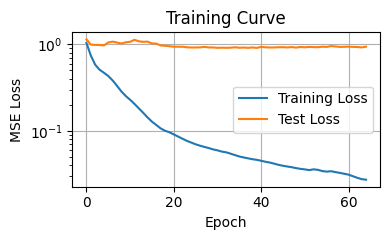

In [ ]:
if not use_trained_model:
    # Plot the training history
    plt.figure(figsize=(4, 2.5))
    plt.plot(losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(fig_dir + latent_id + 'loss_history.png',dpi=300)

In [ ]:
# currently unimplemented run from checkpoint code
# load from checkpoint
# check_dict = 'checkpoints/ldc_15k_checkpoint.pth'
# checkpoint = torch.load(check_dict)
# model.load_state_dict(checkpoint['model_state_dict'])

# check_dict = 'checkpoints/ldc_30k_60ksnaps_best_model.pth'
# checkpoint = torch.load(check_dict)
# model.load_state_dict(checkpoint)

/tmp/ipykernel_6069/3491806761.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(check_dict)


<All keys matched successfully>

#### Save Model Block

In [ ]:
model_name = data_name + '_m' + str(num_modes) + '_p' + str(patch_size) + '_model.pth'
if use_trained_model:
    # load model
    print(f'Loading model from {model_name}')
    state_dict = torch.load('models/' + model_name, weights_only=True)
    # Rename keys to match the current model's naming convention
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("encoder.layers", "encoder_layers")
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    model.eval()
else:
    # save model
    print(f'Saving model to {model_name}')
    torch.save(model.state_dict(), 'models/' + model_name)

Loading model from ldc_30k_60ksnaps_m5_p19_model.pth


In [32]:
# print number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params}")

Number of parameters in the model: 52572748


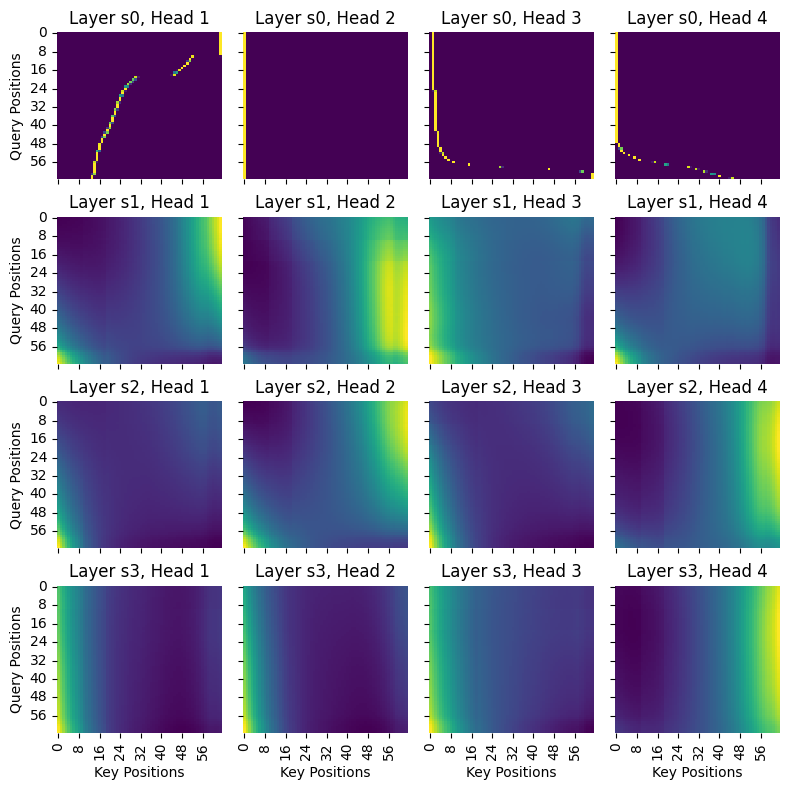

In [32]:
# Forward pass to populate attention weights
model.eval()
with torch.no_grad():
    _ = model(X_train[0].to(device))  # Pass a sample input

# Retrieve and visualize attention weights
attn_weights = model.get_attn()
num_layers = len(attn_weights)
num_heads = next(iter(attn_weights.values())).shape[1]  # Get the number of heads from the first layer's weights

fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 2, num_layers * 2), sharex=True, sharey=True)  
for i, (layer, weights) in enumerate(attn_weights.items()):
    weights = weights.cpu().numpy()
    # weights = weights.squeeze(0)  # Remove the batch dimension
    for j in range(num_heads):
        ax = axes[i, j] if num_layers > 1 else axes[j]
        sns.heatmap(weights[-1,j], cmap="viridis", ax=ax, cbar=False)
        ax.set_title(f"Layer {layer}, Head {j+1}")
        if i == num_layers - 1:
            ax.set_xlabel("Key Positions")
        if j == 0:
            ax.set_ylabel("Query Positions")
            

plt.tight_layout()
plt.savefig(fig_dir + latent_id + 'attention_weights.png', dpi=600)

In [17]:
def visualize_attention(model, layer_idx=0, head_idx=0):
    """
    Visualize attention weights for a specific layer and head.

    Args:
        model: The trained Transformer model.
        layer_idx: Index of the encoder layer to visualize.
        head_idx: Index of the attention head to visualize.
    """
    # Retrieve attention weights using the get_attn() method
    attn_weights = model.get_attn()

    if not attn_weights:
        print("No attention weights found. Run a forward pass first.")
        return

    # Extract attention weights for the specified layer and head
    layer_key = f's{layer_idx}'
    if layer_key not in attn_weights:
        print(f"Layer {layer_idx} not found in attention weights.")
        return

    weights = attn_weights[layer_key].detach().cpu().numpy()
    if head_idx >= weights.shape[1]:
        print(f"Head {head_idx} not found in layer {layer_idx}.")
        return

    # Plot the attention weights as a heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(weights[0, head_idx], cmap="viridis")
    plt.title(f"Attention Weights - Layer {layer_idx}, Head {head_idx}")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

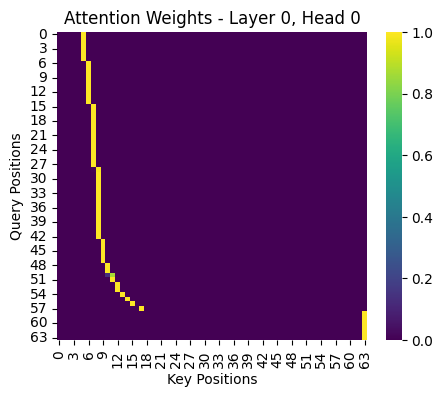

In [18]:
visualize_attention(model, layer_idx=0, head_idx=0)

In [33]:
# delete data loaders to clear space on GPU
del train_loader, train_dataset, test_loader, test_dataset

NameError: name 'train_loader' is not defined

In [34]:
# delete data
del X_train, Y_train, X_test, Y_test

In [35]:
del inputs, targets

NameError: name 'inputs' is not defined

In [36]:
del outputs, loss

NameError: name 'outputs' is not defined

In [37]:
# clear GPU memory
torch.cuda.empty_cache()

## Model Evaluation

### Time history prediction function

In [38]:
# long time history prediction
def predict_long_term(model, initial_input, time_lag, num_predictions):
    """
    Predict long-term future values using the model.

    Args:
        model: The trained model.
        initial_input: The initial input sequence.
        time_lag: The length of the input sequence.
        num_predictions: The number of future values to predict.

    Returns:
        predictions: The predicted future values.
    """
    model.eval()
    predictions = []
    current_input = initial_input

    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_predictions):
            output = model(current_input)
            # print('Output shape: ', output[np.newaxis,:,:].shape)
            predictions.append(output.to('cpu').numpy())  # Ensure tensor is moved to CPU before converting to NumPy
            # Update the input for the next prediction
            current_input = torch.cat((current_input[:,1:, :], output[np.newaxis,:,:]), dim=1)
            # print('Current input shape: ', current_input.shape)

    end_time = time.time()
    print('Time taken for long-term prediction: ', end_time - start_time)
    print('Time taken per prediction: ', (end_time - start_time)/num_predictions)
    return np.array(predictions)

In [39]:
with h5py.File(file, 'r') as f:
    print('Data set shape:', f['UV'].shape)
    print('Data mean shape:', f['mean'].shape)
    u_scaled = f['UV'][:train_size].transpose(3,1,2,0)
    u_mean = f['mean'][:].transpose(2,0,1)
    u_scaled = u_scaled - u_mean[:,:,:,np.newaxis]

Data set shape: (60000, 512, 512, 2)
Data mean shape: (512, 512, 2)


Time taken for long-term prediction:  2.3795976638793945
Time taken per prediction:  0.0025423051964523448


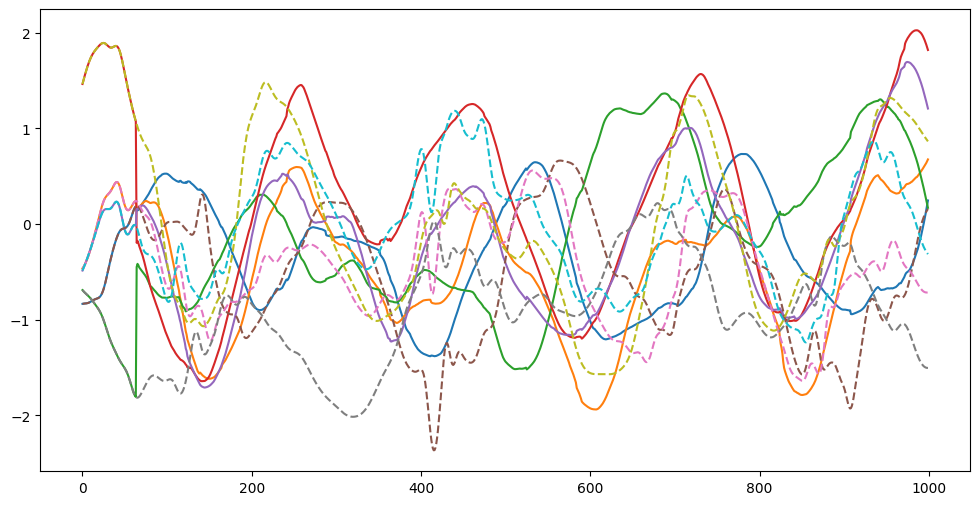

In [40]:
# Predict validation data set starting from the last time step of the training data
initial_input = val_data[:time_lag,:]  # Use the first time_lag+1 samples as the initial input
initial_input = torch.tensor(initial_input[np.newaxis,:,:], dtype=torch.float32).to(device)  # Move to GPU

num_predictions =  num_val-time_lag  # Number of future values to predict
predictions = predict_long_term(model, initial_input, time_lag, num_predictions)
predictions = predictions.reshape(num_predictions, -1)  # Reshape to (num_predictions, input_dim)
predictions = np.vstack([initial_input[0,:,:].cpu().numpy(), predictions])  # Concatenate initial input with predictions

del initial_input
# clear GPU memory
torch.cuda.empty_cache()


# Plot the predictions
plt.figure(figsize=(12, 6))
i = 1000
plt.plot(np.array(predictions)[:, i:i+num_modes], label='Predicted')  # Convert predictions to NumPy array
plt.plot(val_data[:, i:i+num_modes],
                    linestyle='dashed', label='True')

plt.show()

# reconstruct predictions
predictions = denormalize_data(predictions, mean_data, std_data)
pred_u = predictions[:, :config.num_gfem_nodes*config.dof_node]
pred_v = predictions[:, config.num_gfem_nodes*config.dof_node:]
Q_rec = gfem_recon(pred_u.T, pred_v.T, config)

In [ ]:
if animate_flag:
    Q_plot = Q_rec[0,:,:,:] / np.max(np.abs(Q_rec[0]))
    frames = []
    for i in range(num_val-time_lag):  # Number of frames
        fig, ax = plt.subplots()
        im = ax.imshow(Q_plot[:, :, time_lag + i], cmap='seismic', origin='lower', vmin=-1, vmax=1)
        ax = plt.gca()
        for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.tight_layout()
        
        # Save the current frame
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

    # Save as GIF
    imageio.mimsave(anim_dir + 'u_pred_val.gif', frames, fps=30, loop=0)

In [ ]:
if animate_flag:
    Q_plot = u_scaled[0,:config.nx_t,:config.ny_t,num_train:] / np.max(np.abs(u_scaled[0,:config.nx_t,:config.ny_t,num_train:]))
    frames = []
    for i in range(num_val - time_lag):  # Number of frames
        fig, ax = plt.subplots()
        im = ax.imshow(Q_plot[:, :, time_lag + i], cmap='seismic', origin='lower', vmin=-1, vmax=1)
        ax = plt.gca()
        for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.tight_layout()
        
        # Save the current frame
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

    # Save as GIF
    imageio.mimsave(anim_dir + 'u_truth_val.gif', frames, fps=30, loop=0)

In [35]:
# with h5py.File(file, 'r') as f:
#     print('Data set shape:', f['UV'].shape)
#     print('Data mean shape:', f['mean'].shape)
#     u_scaled = f['UV'][:train_size].transpose(3,1,2,0)
#     u_mean = f['mean'][:].transpose(2,0,1)
#     u_scaled = u_scaled - u_mean[:,:,:,np.newaxis]

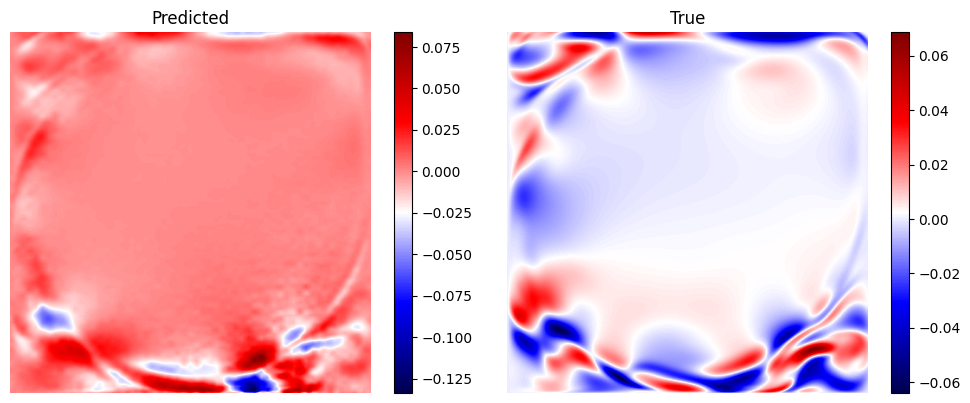

L2 Error Norm between snapshots: 93.42%


In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Predicted
axes[0].imshow(Q_rec[0,:, :, -1], origin='lower', cmap='seismic')
axes[0].set_title('Predicted')
axes[0].axis('off')
fig.colorbar(axes[0].imshow(Q_rec[0,:, :, -1], origin='lower', cmap='seismic'), ax=axes[0])
for spine in axes[0].spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# True
axes[1].imshow(u_scaled[0,:, :, -1], origin='lower', cmap='seismic')
axes[1].set_title('True')
axes[1].axis('off')
fig.colorbar(axes[1].imshow(u_scaled[0,:config.nx_t, :config.ny_t, -1], origin='lower', cmap='seismic'), ax=axes[1])
for spine in axes[1].spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.tight_layout()
plt.show()

# error
error = np.linalg.norm(u_scaled[:,:config.nx_t,:config.ny_t,num_train+time_lag:] - Q_rec[:,:config.nx_t,:config.ny_t,time_lag:]) / np.linalg.norm(u_scaled[:,:config.nx_t,:config.ny_t,num_train+time_lag:])
print(f'L2 Error Norm between snapshots: {error*100:.2f}%')

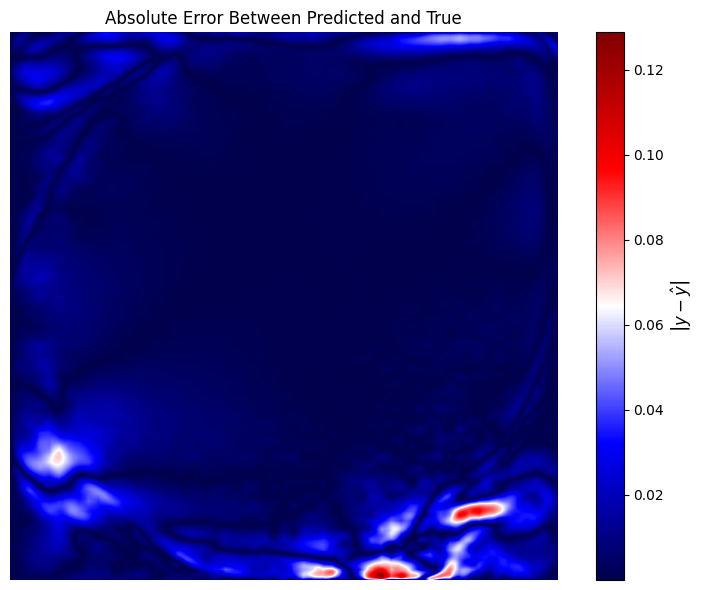

In [44]:
# Plot highest error
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(u_scaled[0,:config.nx_t,:config.ny_t,-1] - Q_rec[0,:config.nx_t,:config.ny_t,-1]), origin='lower', cmap='seismic')
cbar = plt.colorbar()
cbar.set_label(r'$\left| y - \hat{y} \right|$', fontsize=12)

plt.title('Absolute Error Between Predicted and True')
plt.axis('off')
plt.tight_layout()

### RMS of Predictions vs Truth
The root mean square of the fluctuations in velocity


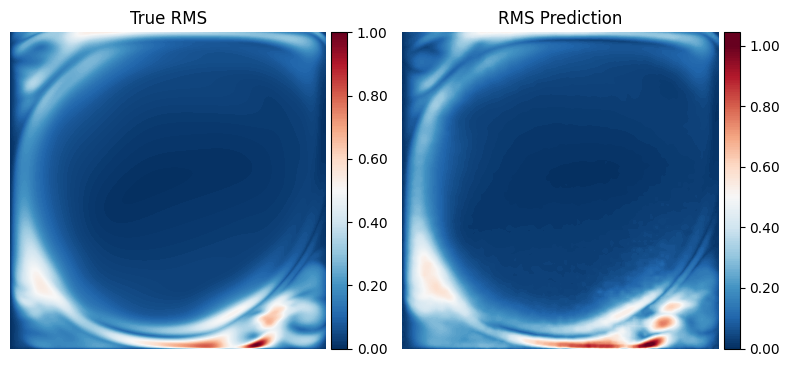

In [45]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def RMS(y, axis=None):
    return np.sqrt(np.mean(y ** 2, axis=axis))

U_true = u_scaled[:,:config.nx_t,:config.ny_t,num_train+time_lag:]
U_pred = Q_rec[:,:config.nx_t,:config.ny_t,time_lag:]

RMS_true = RMS(U_true, axis=-1)
RMS_pred = RMS(U_pred, axis=-1)

RMS_max = np.max(RMS_true, axis=(1,2), keepdims=True)
RMS_true_plot = RMS_true / RMS_max
RMS_pred_plot = RMS_pred / RMS_max

x = np.linspace(0, 1, config.nx)
y = np.linspace(0, 1, config.ny)
x = x[:config.nx_t]
y = y[:config.ny_t]
X, Y = np.meshgrid(x, y)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

def add_colorbar(ax, im, ticks=None):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, format='%.2f', ticks=ticks)
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Example usage with fewer ticks
ticks = np.linspace(0, 1, 6)

c1 = axs[0].contourf(X, Y, RMS_true_plot[0], levels=200, cmap='RdBu_r', vmin=0, vmax=1)
add_colorbar(axs[0], c1, ticks=ticks)
axs[0].set_title('True RMS')
axs[0].axis('off')
axs[0].set_aspect('equal')

c2 = axs[1].contourf(X, Y, RMS_pred_plot[0], levels=200, cmap='RdBu_r', vmin=0, vmax=1)
add_colorbar(axs[1], c2, ticks=ticks)
axs[1].set_title('RMS Prediction')
axs[1].axis('off')
axs[1].set_aspect('equal')

fig.set_tight_layout(True)
plt.savefig(fig_dir + latent_id + 'RMS.png', dpi=600)

In [46]:
# RMS error
RMS_error = np.linalg.norm(RMS_true - RMS_pred) / np.linalg.norm(RMS_true)
print(f'RMS L2 Error Norm: {RMS_error*100:.2f}%')

RMS L2 Error Norm: 19.14%


### Vorticity of data for visualization purposes

In [47]:
grid_x = np.linspace(1, 512, 512)
grid_y = np.linspace(1, 512, 512)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)

with h5py.File(file, 'r') as f:
    print(f['UV'].shape)
    vort_data = f['UV'][:4,:,:,:]

vort_data = vort_data.transpose(1,2,3,0)
    
vort = curl(grid_x, grid_y, vort_data[0,:,:,:], vort_data[1,:,:,:])

print(vort.shape)

vort_min = np.min(vort)
vort_max = np.max(vort)

(60000, 512, 512, 2)
(512, 2, 4)


### Visualize point probe locations for frequency analysis

y_closest:  0.11154598825831702
x_closest1:  0.2328767123287671
x_closest2:  0.7651663405088063


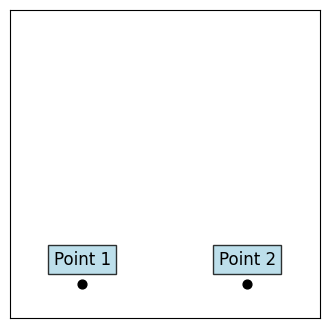

In [48]:
x = np.linspace(0, 1, config.nx)
y = np.linspace(0, 1, config.ny)
x = x[:config.nx_t]
y = y[:config.ny_t]
X, Y = np.meshgrid(x, y)

# find y closest  = 0.112
y_closest = np.argmin(np.abs(y - 0.112))
print('y_closest: ', y[y_closest])

# find x closest to 0.233 and 0.765
x_closest1 = np.argmin(np.abs(x - 0.233))
x_closest2 = np.argmin(np.abs(x - 0.765))
print('x_closest1: ', x[x_closest1])
print('x_closest2: ', x[x_closest2])

point_1 = (x[x_closest1], y[y_closest])
point_2 = (x[x_closest2], y[y_closest])
point_1_idx = (x_closest1, y_closest)
point_2_idx = (x_closest2, y_closest)

# Create a plot that shows the points in the domain
plt.figure(figsize=(4, 4))
# plt.contourf(grid_x/512, grid_y/512, vort[:,:,-1], cmap='seismic', levels=1000, vmin=vort_min, vmax=vort_max)
plt.scatter(point_1[0], point_1[1], color='k', label='Point 1', s=40)
plt.scatter(point_2[0], point_2[1], color='k', label='Point 2', s=40)
plt.text(point_1[0], point_1[1]+0.05, f'Point 1', 
         color='k', fontsize=12, va='bottom', ha='center', bbox=dict(facecolor='lightblue', alpha=0.8))
plt.text(point_2[0], point_2[1]+0.05, f'Point 2', 
         color='k', fontsize=12, va='bottom', ha='center', bbox=dict(facecolor='lightblue', alpha=0.8))
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.grid()
plt.axis('equal')
# plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)

plt.savefig(fig_dir + 'points.png', dpi=600)

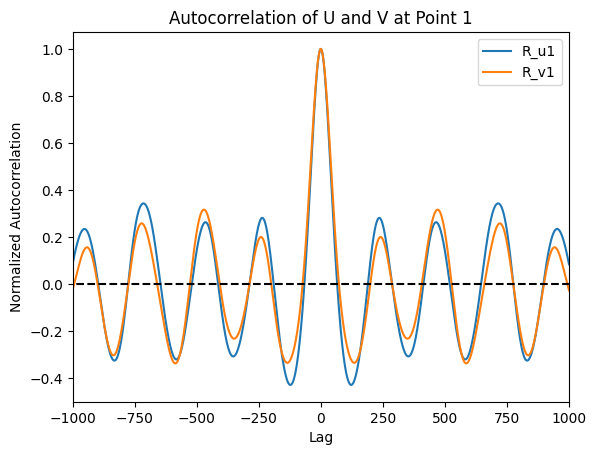

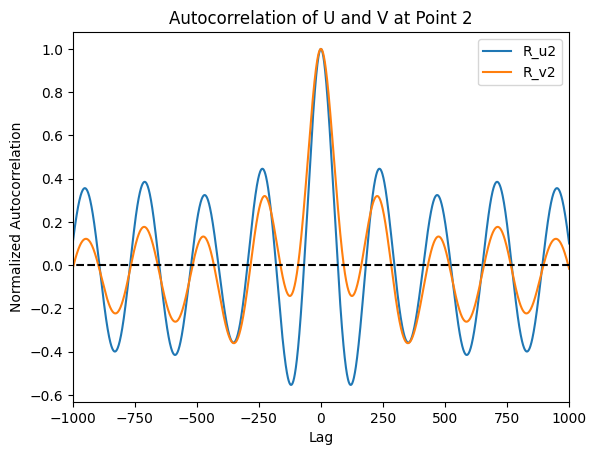

In [49]:
from scipy.signal import welch, correlate, coherence, correlation_lags

# Point 1
with h5py.File(file, 'r') as f:
    u_p1 = f['UV'][:10000,point_1_idx[0], point_1_idx[1],:]
    u_mean_p1 = f['mean'][point_1_idx[0], point_1_idx[1],:]
    # print(u_p1.shape, u_mean_p1.shape)

R_u1 = correlate(u_p1[:,0] - u_mean_p1[np.newaxis,0], u_p1[:,0] - u_mean_p1[np.newaxis,0], mode='same') 
R_v1 = correlate(u_p1[:,1] - u_mean_p1[np.newaxis,1], u_p1[:,1] - u_mean_p1[np.newaxis,1], mode='same')
lags = correlation_lags(u_p1[:,0].size, u_p1[:,0].size, mode='same')

plt.plot(lags, R_u1 / R_u1[lags==0], label='R_u1')
plt.plot(lags, R_v1 / R_v1[lags==0], label='R_v1')
plt.hlines(0, lags[0], lags[-1], colors='k', linestyles='dashed')
plt.title('Autocorrelation of U and V at Point 1')
plt.xlabel('Lag')
plt.xlim(-1000, 1000)
plt.ylabel('Normalized Autocorrelation')
plt.legend()
plt.show()

# Point 2
with h5py.File(file, 'r') as f:
    u_p2 = f['UV'][:10000,point_2_idx[0], point_2_idx[1],:]
    u_mean_p2 = f['mean'][point_2_idx[0], point_2_idx[1],:]
    # print(u_p2.shape, u_mean_p2.shape)

R_u2 = correlate(u_p2[:,0] - u_mean_p2[np.newaxis,0], u_p2[:,0] - u_mean_p2[np.newaxis,0], mode='same')
R_v2 = correlate(u_p2[:,1] - u_mean_p2[np.newaxis,1], u_p2[:,1] - u_mean_p2[np.newaxis,1], mode='same')
lags = correlation_lags(u_p2[:,0].size, u_p2[:,0].size, mode='same')
plt.plot(lags, R_u2 / R_u2[lags==0], label='R_u2')
plt.plot(lags, R_v2 / R_v2[lags==0], label='R_v2')
plt.hlines(0, lags[0], lags[-1], colors='k', linestyles='dashed')
plt.title('Autocorrelation of U and V at Point 2')
plt.xlabel('Lag')
plt.xlim(-1000, 1000)
plt.ylabel('Normalized Autocorrelation')
plt.legend()
plt.show()


### PSDs of Data at Point Probes 

PSD: Frequency binned data by measuring correlation with complex sine wave of that frequency

CPSD: Frequency binned correlation between two signals, measures correlation between frequencies

MagSquareCoherence: Not as useful

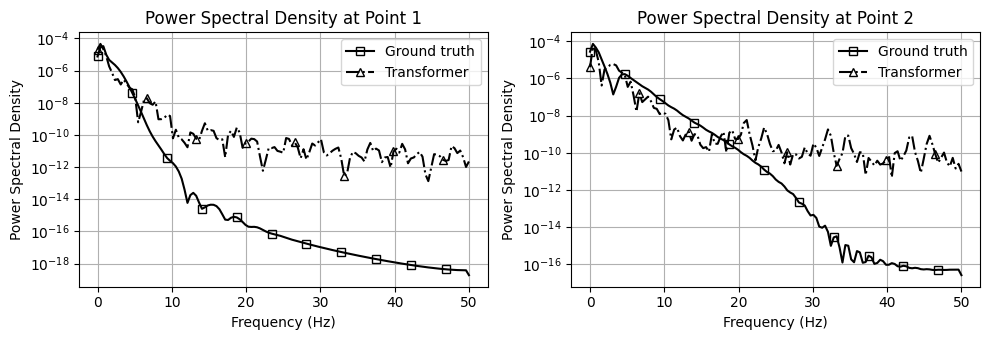

<Figure size 1000x350 with 0 Axes>

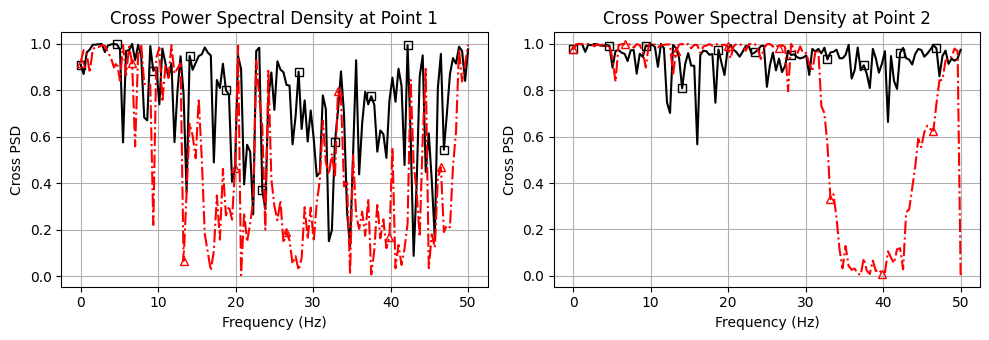

<Figure size 647.2x400 with 0 Axes>

<Figure size 647.2x400 with 0 Axes>

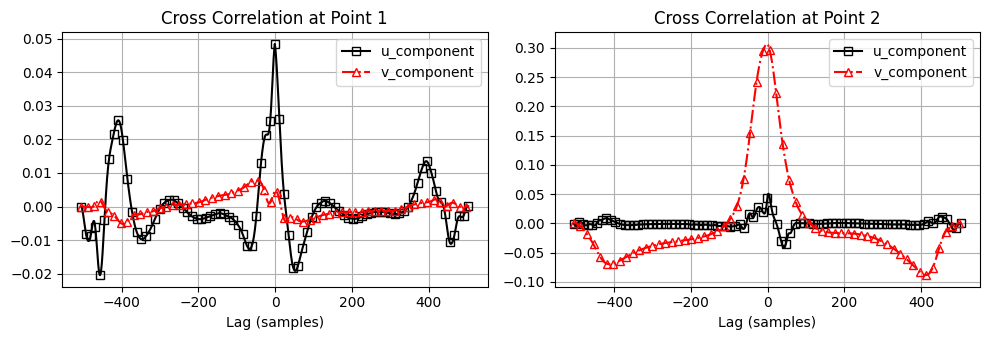

In [77]:
from scipy.signal import welch, correlate, coherence

def compute_psd(data, point_idx, fs=100, nperseg=128):
    f, Pxx_u = welch(data[:, point_idx[0], point_idx[1]]-np.mean(data[:, point_idx[0], point_idx[1]]), fs)
    return f, Pxx_u

def compute_cross_psd(data1, data2, point_idx, fs=100, nperseg=128):
    f, Cxy = coherence(data1[:, point_idx[0], point_idx[1]], data2[:, point_idx[0], point_idx[1]], fs)
    return f, Cxy

def compute_cross_correlation(data1, data2, point_idx):
    Rxy = correlate(data1[:, point_idx[0], point_idx[1]]-np.mean(data1[:, point_idx[0], point_idx[1]]),
                    data2[:, point_idx[0], point_idx[1]]-np.mean(data2[:, point_idx[0], point_idx[1]]), mode='full')
    return Rxy

# Compute PSD for true, LSTM, and transformer data at points 1 and 2
f, Pxx_true_1_u = compute_psd(U_true[0], point_1_idx)
f, Pxx_true_2_u = compute_psd(U_true[0], point_2_idx)
f, Pxx_true_1_v = compute_psd(U_true[1], point_1_idx)
f, Pxx_true_2_v = compute_psd(U_true[1], point_2_idx)
f, Pxx_transformer_1_u = compute_psd(U_pred[0], point_1_idx)
f, Pxx_transformer_2_u = compute_psd(U_pred[0], point_2_idx)
f, Pxx_transformer_1_v = compute_psd(U_pred[1], point_1_idx)
f, Pxx_transformer_2_v = compute_psd(U_pred[1], point_2_idx)

# Compute cross PSD for true and transformer data at points 1 and 2
f, Cxy_1_u = compute_cross_psd(U_true[0], U_pred[0], point_1_idx)
f, Cxy_2_u = compute_cross_psd(U_true[0], U_pred[0], point_2_idx)
f, Cxy_1_v = compute_cross_psd(U_true[1], U_pred[1], point_1_idx)
f, Cxy_2_v = compute_cross_psd(U_true[1], U_pred[1], point_2_idx)

# Compute cross-correlation for true and transformer data at points 1 and 2
Rxy_u_1 = compute_cross_correlation(U_true[0], U_pred[0], point_1_idx)
Rxy_u_2 = compute_cross_correlation(U_true[0], U_pred[0], point_2_idx)
Rxy_v_1 = compute_cross_correlation(U_true[1], U_pred[1], point_1_idx)
Rxy_v_2 = compute_cross_correlation(U_true[1], U_pred[1], point_2_idx)

# Plot the power spectral density
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

def plot_psd(ax, f, Pxx_true, Pxx_transformer, title, ylabel):
    ax.semilogy(f, Pxx_true, label='Ground truth', color='k', linestyle='-', marker='s', markevery=12, markerfacecolor='none')
    ax.semilogy(f, Pxx_transformer, label='Transformer', color='k', linestyle='-.', marker='^', markevery=17, markerfacecolor='none')
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid()

def plot_cross_psd(ax, f, Cxy_u, Cxy_v, title, ylabel):
    plt.figure(figsize=(4*1.618, 4))
    ax.plot(f, Cxy_u, label='u component', color='k', linestyle='-', marker='s', markevery=12, markerfacecolor='none')
    ax.plot(f, Cxy_v, label='v component', color='r', linestyle='-.', marker='^', markevery=17, markerfacecolor='none')
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(ylabel)
    # ax.legend()
    ax.grid()

def plot_cross_correlation(ax, Rxy_u, Rxy_v, title):
    f = np.arange(-len(Rxy_u)//2, len(Rxy_u)//2)
    ax.plot(f, Rxy_u, label='u_component', color='k', linestyle='-', marker='s', markevery=12, markerfacecolor='none')
    ax.plot(f, Rxy_v, label='v_component', color='r', linestyle='-.', marker='^', markevery=17, markerfacecolor='none')
    ax.set_title(title)
    ax.set_xlabel('Lag (samples)')
    ax.legend()
    ax.grid()

plot_psd(axs[0], f, Pxx_true_1_u, Pxx_transformer_1_u, 'Power Spectral Density at Point 1', 'Power Spectral Density')
plot_psd(axs[1], f, Pxx_true_2_u, Pxx_transformer_2_u, 'Power Spectral Density at Point 2', 'Power Spectral Density')

fig.tight_layout()
fig.savefig(fig_dir + latent_id + 'psd_compare.png', dpi=600)

# Cumulative sum of the PSD
def compute_cumulative_psd(f, Pxx):
    return np.cumsum(Pxx) / np.sum(Pxx)

# Compute cumulative PSD for true and transformer data at points 1 and 2
cumulative_psd_true_1 = compute_cumulative_psd(f, Pxx_true_1_u)
cumulative_psd_true_2 = compute_cumulative_psd(f, Pxx_true_2_u)
cumulative_psd_transformer_1 = compute_cumulative_psd(f, Pxx_transformer_1_u)
cumulative_psd_transformer_2 = compute_cumulative_psd(f, Pxx_transformer_2_u)

plt.figure(figsize=(10, 3.5))
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
plot_cross_psd(axs[0], f, Cxy_1_u, Cxy_1_v, 'Cross Power Spectral Density at Point 1', 'Cross PSD')
plot_cross_psd(axs[1], f, Cxy_2_u, Cxy_2_v, 'Cross Power Spectral Density at Point 2', 'Cross PSD')
fig.tight_layout()
plt.savefig(fig_dir + latent_id + 'cross_psd.png', dpi=600)

# Plot the cross-correlation
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
plot_cross_correlation(axs[0], Rxy_u_1, Rxy_v_1, 'Cross Correlation at Point 1')
plot_cross_correlation(axs[1], Rxy_u_2, Rxy_v_2, 'Cross Correlation at Point 2')
fig.tight_layout()
plt.savefig(fig_dir + latent_id + 'msc.png', dpi=600)


### Sum of Squares of the GFEM Coefficients, TKE

TKE error: 43.23%


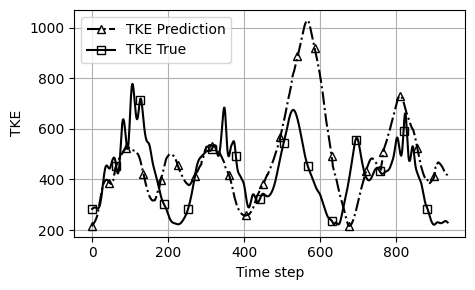

In [ ]:
# TKE of coefficients
pred = predictions[time_lag:, :]
truth = denormalize_data(val_data[time_lag:, :], mean_data, std_data)

TKE_pred = 1/2 * np.sum((pred)**2, axis = 1)
TKE_truth = 1/2 * np.sum((truth)**2, axis = 1)

TKE_error = np.linalg.norm(TKE_pred - TKE_truth) / np.linalg.norm(TKE_truth)
print(f'TKE error: {TKE_error*100:.2f}%')

plt.figure(figsize=(3*1.618, 3))
plt.plot(TKE_pred, color='k', linestyle='-.', marker='^', markevery=45, markerfacecolor='none', label='TKE Prediction')
plt.plot(TKE_truth, color='k', linestyle='-', marker='s', markevery=63, markerfacecolor='none', label='TKE True')
plt.xlabel('Time step')
plt.ylabel('TKE')
plt.legend()
plt.grid()

plt.tight_layout()

plt.savefig(fig_dir + latent_id + 'TKE_coeff.png', dpi=600)

### Sum of Squares of the Reconstructed Data, TKE

TKE error: 20.38%


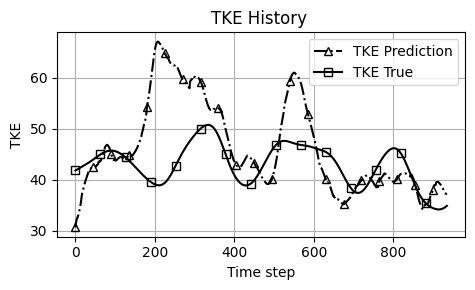

In [ ]:
# TKE of whole reconstruction
TKE_pred = 1/2 * np.sum((Q_rec[:,:,:,time_lag:])**2, axis = (0,1,2))
TKE_truth = 1/2 * np.sum((u_scaled[:,:config.nx_t,:config.ny_t,num_train+time_lag:])**2, axis = (0,1,2))

TKE_error = np.linalg.norm(TKE_pred - TKE_truth) / np.linalg.norm(TKE_truth)
print(f'TKE error: {TKE_error*100:.2f}%')

plt.figure(figsize=(3*1.618, 3))
plt.plot(TKE_pred, color='k', linestyle='-.', marker='^', markevery=45, markerfacecolor='none', label='TKE Prediction')
plt.plot(TKE_truth, color='k', linestyle='-', marker='s', markevery=63, markerfacecolor='none', label='TKE True')
plt.title('TKE History ')
plt.xlabel('Time step')
plt.ylabel('TKE')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(fig_dir + latent_id + 'TKE.png', dpi=600)

### Init on Train

Time taken for long-term prediction:  11.899756908416748
Time taken per prediction:  0.002410809746437753


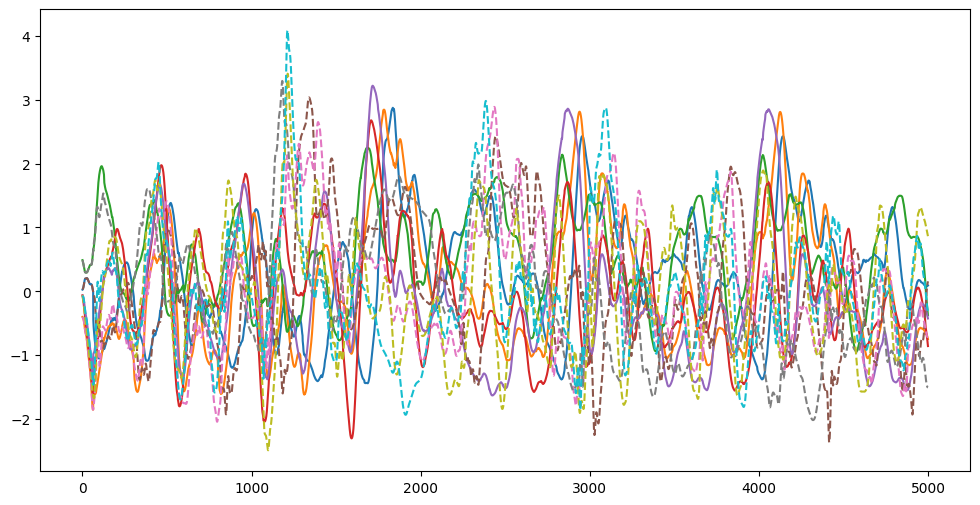

In [53]:
initial_input = normalized_data[:time_lag,:]  # Use the first time_lag+1 samples as the initial input
initial_input = torch.tensor(initial_input[np.newaxis,:,:], dtype=torch.float32).to(device)  # Move to GPU


num_predictions =  train_size-time_lag  # Number of future values to predict
predictions = predict_long_term(model, initial_input, time_lag, num_predictions)
predictions = predictions.reshape(num_predictions, -1)  # Reshape to (num_predictions, input_dim)
predictions = np.vstack([initial_input[0,:,:].cpu().numpy(), predictions])  # Concatenate initial input with predictions

del initial_input
# clear GPU memory
torch.cuda.empty_cache()


# Plot the predictions
plt.figure(figsize=(12, 6))
i = 1000
plt.plot(np.array(predictions)[:, i:i+num_modes], label='Predicted')  # Convert predictions to NumPy array
plt.plot(normalized_data[:, i:i+num_modes],
                    linestyle='dashed', label='True')

plt.show()

# reconstruct predictions
predictions = denormalize_data(predictions, mean_data, std_data)
pred_u = predictions[:, :config.num_gfem_nodes*config.dof_node]
pred_v = predictions[:, config.num_gfem_nodes*config.dof_node:]
Q_rec = gfem_recon(pred_u.T, pred_v.T, config)

In [54]:
with h5py.File(file, 'r') as f:
    print('Data set shape:', f['UV'].shape)
    print('Data mean shape:', f['mean'].shape)
    u_scaled = f['UV'][:train_size].transpose(3,1,2,0)
    u_mean = f['mean'][:].transpose(2,0,1)
    u_scaled = u_scaled - u_mean[:,:,:,np.newaxis]

Data set shape: (60000, 512, 512, 2)
Data mean shape: (512, 512, 2)


In [55]:
# Q_rec TKE
TKE_pred = 1/2 * np.sum((Q_rec[:,:,:,time_lag:])**2, axis = (0,1,2))
TKE_truth = 1/2 * np.sum((u_scaled[:,:config.nx_t,:config.ny_t,time_lag:train_size])**2, axis = (0,1,2))

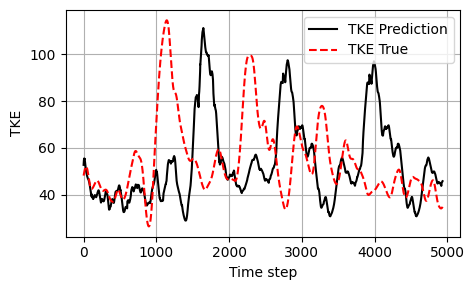

In [56]:
plt.figure(figsize=(3*1.618, 3))
plt.plot(TKE_pred, color='k', linestyle='-', label='TKE Prediction')
plt.plot(TKE_truth, color='r', linestyle='--', label='TKE True')
plt.xlabel('Time step')
plt.ylabel('TKE')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(fig_dir + latent_id + 'TKE_whole_set.png', dpi=600)

In [ ]:
if animate_flag:
    Q_plot = Q_rec[0,:,:,:] / np.max(np.abs(Q_rec[0]))
    frames = []
    for i in range((Q_plot.shape[-1] - time_lag)//2):  # Number of frames
        fig, ax = plt.subplots()
        im = ax.imshow(Q_plot[:, :, time_lag + 2*i ], cmap='seismic', origin='lower', vmin=-1, vmax=1)
        ax = plt.gca()
        for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.tight_layout()
        
        # Save the current frame
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

    # Save as GIF
    imageio.mimsave(anim_dir + 'u_pred_train.gif', frames, fps=30, loop=0)

In [ ]:
if animate_flag:
    Q_plot = u_scaled[0,:config.nx_t,:config.ny_t,:] / np.max(np.abs(u_scaled[0,:config.nx_t,:config.ny_t,:]))
    frames = []
    for i in range((Q_plot.shape[-1] - time_lag)//2):  # Number of frames
        fig, ax = plt.subplots()
        im = ax.imshow(Q_plot[:, :, time_lag + 2*i], cmap='seismic', origin='lower', vmin=-1, vmax=1)
        ax = plt.gca()
        for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.tight_layout()
        
        # Save the current frame
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(frame)
        plt.close(fig)

    # Save as GIF
    imageio.mimsave(anim_dir + 'u_truth_train.gif', frames, fps=30, loop=0)

### Very Long Predictions

Time taken for long-term prediction:  23.58349609375
Time taken per prediction:  0.002358349609375


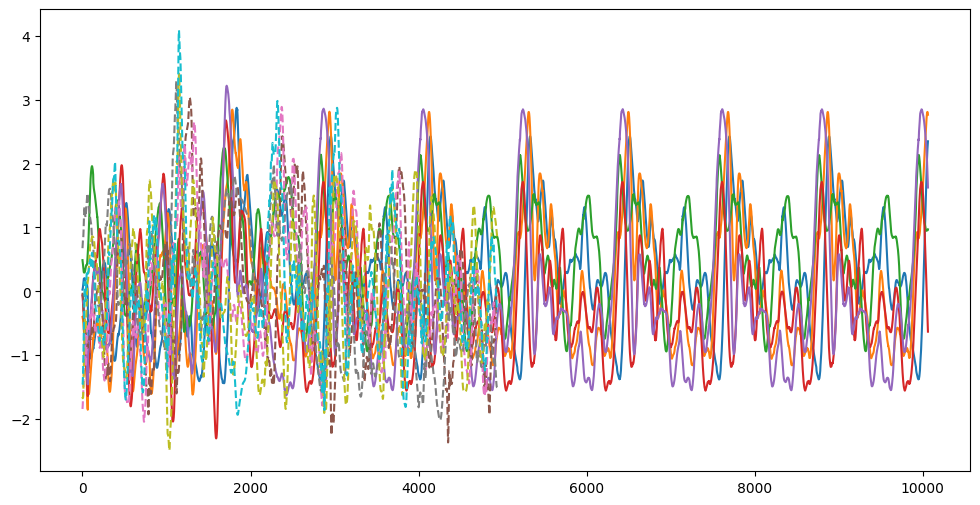

In [ ]:
# Predict validation data set starting from the last time step of the training data

initial_input = normalized_data[:time_lag,:]  # Use the first time_lag+1 samples as the initial input
initial_input = torch.tensor(initial_input[np.newaxis,:,:], dtype=torch.float32).to(device)  # Move to GPU

num_predictions =  10000  # Number of future values to predict
predictions = predict_long_term(model, initial_input, time_lag, num_predictions)
predictions = predictions.reshape(num_predictions, -1)  # Reshape to (num_predictions, input_dim)
predictions = np.vstack([initial_input[0,:,:].cpu().numpy(), predictions])  # Concatenate initial input with predictions

del initial_input
# clear GPU memory
torch.cuda.empty_cache()


# Plot the predictions
# plt.figure(figsize=(12, 6))
# i = 1000
# plt.plot(np.array(predictions)[:, i:i+num_modes], label='Predicted')  # Convert predictions to NumPy array
# plt.plot(normalized_data[time_lag:, i:i+num_modes],
#                     linestyle='dashed', label='True')

# plt.show()

# reconstruct predictions
predictions = denormalize_data(predictions, mean_data, std_data)
# pred_u = predictions[:, :config.num_gfem_nodes*config.dof_node]
# pred_v = predictions[:, config.num_gfem_nodes*config.dof_node:]
# Q_rec = gfem_recon(pred_u.T, pred_v.T, config)

In [70]:
with h5py.File(latent_file, 'r') as f:
    print('Latent space shape:', f['dof_u'].shape)
    if data_name == 'ldc_30k_60ksnaps':
        long_dof_u = f['dof_u'][:num_predictions + time_lag]
        long_dof_v = f['dof_v'][:num_predictions + time_lag]
    else:
        long_dof_u = f['dof_u'][:]
        long_dof_v = f['dof_v'][:]

long_data = np.concatenate((long_dof_u , long_dof_v), axis=1)
    

Latent space shape: (60000, 19494)


TKE error: 64.94% over 10000 time steps


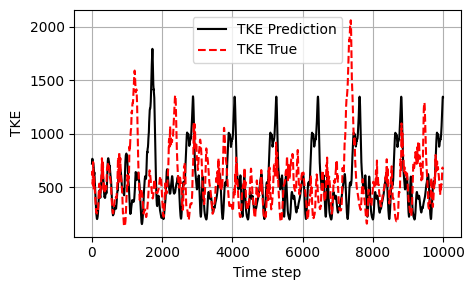

In [ ]:
# TKE of coefficients
TKE_pred = 1/2 * np.sum((predictions[time_lag:])**2, axis = 1)
TKE_truth = 1/2 * np.sum((long_data[time_lag:])**2, axis = 1)

TKE_error = np.linalg.norm(TKE_pred[:TKE_truth.shape[0]] - TKE_truth) / np.linalg.norm(TKE_truth)
print(f'TKE error: {TKE_error*100:.2f}% over {TKE_truth.shape[0]} time steps')
plt.figure(figsize=(3*1.618, 3))
plt.plot(TKE_pred, color='k', linestyle='-', label='TKE Prediction')
plt.plot(TKE_truth, color='r', linestyle='--', label='TKE True')
plt.xlabel('Time step')
plt.ylabel('TKE')
plt.legend()
plt.grid()

plt.tight_layout()

plt.savefig(fig_dir + 'TKE_coeff_long.png', dpi=600)